In [ ]:
import netket as nk
import netket.experimental as nkx
from netket.experimental.operator.fermion import destroy as c
from netket.experimental.operator.fermion import create as cdag
from netket.experimental.operator.fermion import number as nc
from scipy.sparse.linalg import eigsh
import numpy as np
import scipy.sparse.linalg
import jax
import jax.numpy as jnp
import json
import matplotlib.pyplot as plt
from pathlib import Path

import sys, os
sys.path.append('/Users/wttai/Documents/Jupyter/machine_learning/common_lib')
sys.path.append('/home1/wttai/machine_learning/common_lib')
from models import get_qwz_graph, get_qwz_Ham
from networks import *
from helper import get_ed_data
import h5py
from tenpy.tools import hdf5_io

In [16]:
L = 4
N = 8
m = 1.0
U = 0.0
query_dict_dmrg =  {"L": L, "N": N, "t": 1.0, "U": U, "m": m, "pbc": True}
date_dmrg = "20241128_2048"
BASE_PATH_DMRG = Path(f"/home1/wttai/machine_learning/dmrg_qwz/data/netket_qwz_{date_dmrg}")

data_dmrg = []
for root, dirs, files in os.walk(BASE_PATH_DMRG):
    for name in files:
        path = os.path.join(root, name)
        print(path)
        with h5py.File(path, 'r') as f:
            data = hdf5_io.load_from_hdf5(f)
            metadata = data["metadata"]
            matched = True
            for key, value in query_dict_dmrg.items():
                if metadata[key] != value:
                    matched = False
                    break
            if matched:
                data_dmrg.append(data)

In [17]:
print(data_dmrg)

[]


/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_20241126_2143/L=4_N=8_t=1.0_m=1.0_U=0.0_pbc/slater_log_n_samples=8192.json
/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_20241126_2143/L=4_N=8_t=1.0_m=1.0_U=0.0_pbc/nb_log_n_hidden=32_n_hidden_layers=1_n_samples=8192.json
/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_20241126_2143/L=4_N=8_t=1.0_m=1.0_U=0.0_pbc/nj_log_n_hidden=128_n_hidden_layers=1_n_samples=8192.json
/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_20241126_2143/L=4_N=8_t=1.0_m=1.0_U=0.0_pbc/nj_log_n_hidden=32_n_hidden_layers=1_n_samples=8192.json
/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_20241126_2143/L=4_N=8_t=1.0_m=1.0_U=0.0_pbc/nb_log_n_hidden=32_n_hidden_layers=2_n_samples=8192.json
/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_20241126_2143/L=4_N=8_t=1.0_m=1.0_U=0.0_pbc/nj_log_n_hidden=32_n_hidden_layers=2_n_samples=8192.json
/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_20241126_2143/L=4_N=

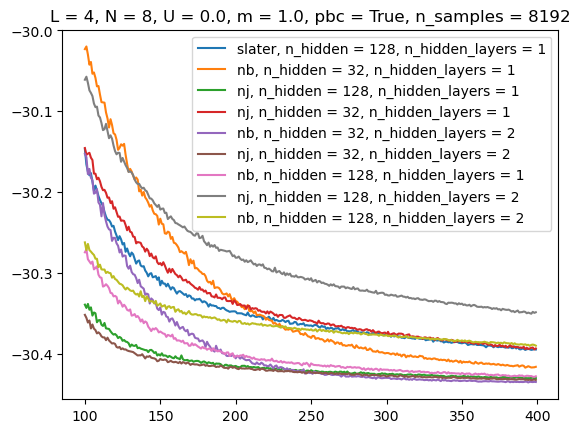

In [12]:
L = 4
N = 8
m = 1.0
U = 0.0
n_samples = 8192
#query_dict = {"L": L, "N": N, "t": 1.0, "U": U, "m": m, "pbc": True,  "n_hidden": 128, "n_hidden_layers": 1}
query_dict = {"L": L, "N": N, "t": 1.0, "U": U, "m": m, "pbc": True, "n_samples": n_samples}   
#date_netket = "20241128_2048"
date_netket = "20241126_2143"
BASE_PATH = Path(f"/home1/wttai/machine_learning/netket_qwz/data/netket_qwz_{date_netket}")

data_to_plot = []
for root, dirs, files in os.walk(BASE_PATH):
    for name in files:
        path = os.path.join(root, name)
        data = json.load(open(path))
        metadata = data["metadata"]
        matched = True
        for key, value in query_dict.items():
            if metadata[key] != value:
                matched = False
                break
        if matched:
            print(path)
            data_to_plot.append(data)

for data in data_to_plot:
    plt.plot(data['data']["Energy"]["iters"], data['data']["Energy"]['Mean']['real'], label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")
title = f"L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
plt.title(title)
plt.legend()

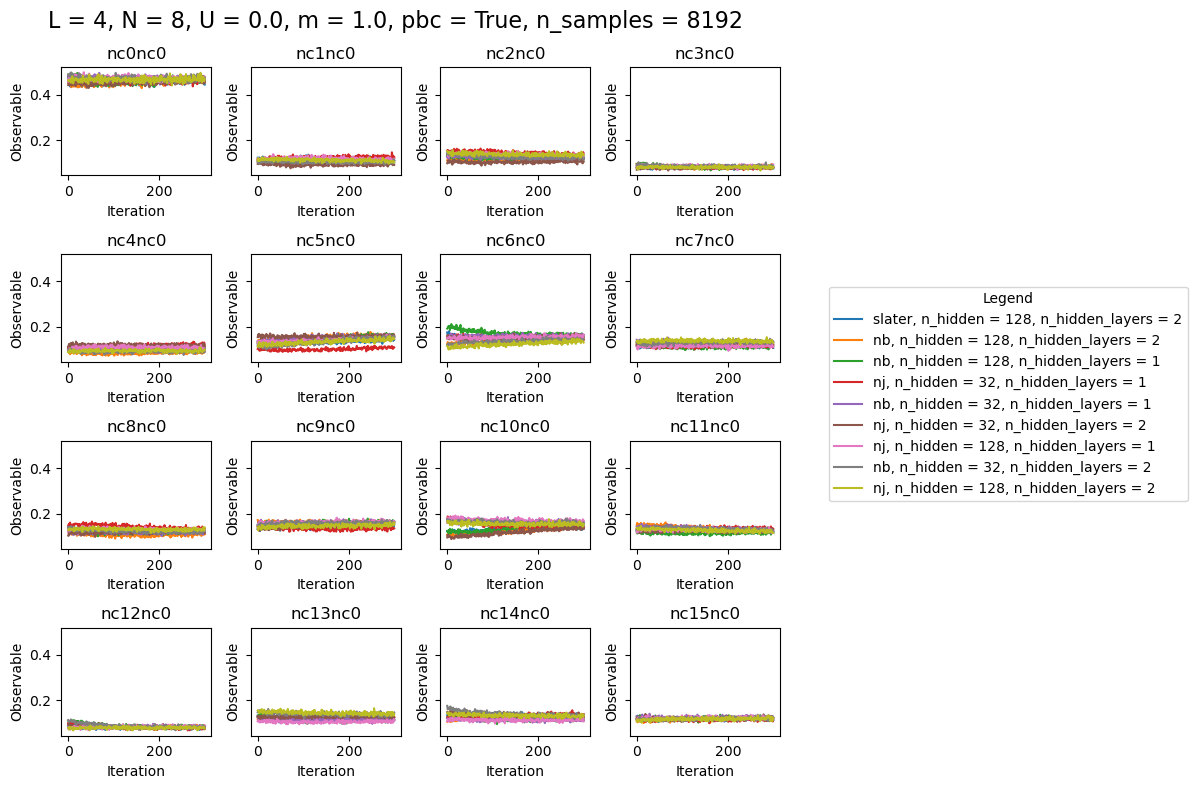

In [8]:
n_corrs = L**2

x_values = np.arange(len(data["data"]['nc0nc0']['Mean']['real']))

# Create a figure and a set of subplots
fig, axs = plt.subplots(4, 4, figsize=(8, 8), sharey=True)

lines = []
labels = []

for data in data_to_plot:
    for i in range(n_corrs):
        x = i // L
        y = i % L
        corr = f"nc{i}nc0"
        line, = axs[x][y].plot(x_values, 
                               data["data"][corr]['Mean']['real'], 
                               label=f"{data["metadata"]["model"]}, n_hidden = {data["metadata"]["n_hidden"]}, n_hidden_layers = {data["metadata"]["n_hidden_layers"]}")
        axs[x][y].set_title(corr)
        axs[x][y].set_xlabel('Iteration')
        axs[x][y].set_ylabel('Observable')

        # Collect lines and labels for the legend
        if line.get_label() not in labels:
            lines.append(line)
            labels.append(line.get_label())

title = f"L = {L}, N = {N}, U = {U}, m = {m}, pbc = {query_dict['pbc']}, n_samples = {n_samples}"
fig.suptitle(title, fontsize=16)

# Add a shared legend to the right of the figure
fig.legend(
    lines, labels, 
    loc='center right', 
    title="Legend", 
    bbox_to_anchor=(1.5, 0.5)
)


# Show the plot
plt.tight_layout()
plt.show()


/home1/wttai/TeNPy/tenpy/tools/hdf5_io.py:1104: UserWarning: Can't import class FermiHubbardSquare from __main__
  warnings.warn(msg, UserWarning)


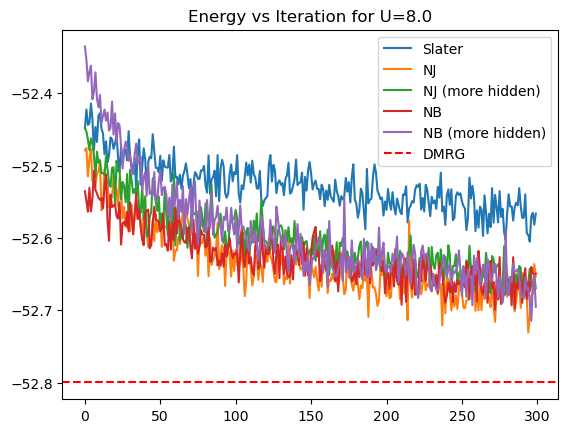

In [23]:
BASE_PATH = Path("/home1/wttai/machine_learning/netket_qwz/data")
t = 1.0
m = 5.0
U = 8.0
date_netket = "20241115_1827"
slater_filename = f"netket_qwz_{date_netket}/slater_log_L=4_N=8_t={t}_m={m}_U={U}.json"
nj_filename = f"netket_qwz_{date_netket}/nj_log_L=4_N=8_t={t}_m={m}_U={U}_n_hidden=32_n_hidden_layers=1.json"
nj_deep_filename = f"netket_qwz_{date_netket}/nj_log_L=4_N=8_t={t}_m={m}_U={U}_n_hidden=128_n_hidden_layers=2.json"
nb_filename = f"netket_qwz_{date_netket}/nb_log_L=4_N=8_t={t}_m={m}_U={U}_n_hidden=32_n_hidden_layers=1.json"
nb_deep_filename = f"netket_qwz_{date_netket}/nb_log_L=4_N=8_t={t}_m={m}_U={U}_n_hidden=128_n_hidden_layers=2.json"

path = BASE_PATH / slater_filename
data_slater = json.load(open(path))
plt.plot(data_slater['data']["Energy"]['Mean']['real'], label='Slater')

path = BASE_PATH / nj_filename
data_nj = json.load(open(path))
plt.plot(data_nj['data']["Energy"]['Mean']['real'], label='NJ')

path = BASE_PATH / nj_deep_filename
data_nj_deep = json.load(open(path))
plt.plot(data_nj_deep['data']["Energy"]['Mean']['real'], label='NJ (more hidden)')

path = BASE_PATH / nb_filename
data_nb = json.load(open(path))
plt.plot(data_nb['data']["Energy"]['Mean']['real'], label='NB')

path = BASE_PATH / nb_deep_filename
data_nb_deep = json.load(open(path))
plt.plot(data_nb_deep['data']["Energy"]['Mean']['real'], label='NB (more hidden)')

date_dmrg = "20241115_1827"
dmrgFilename=f"/home1/wttai/machine_learning/dmrg_qwz/data/dmrg_qwz_{date_dmrg}/dmrg_log_L=4_N=8_t={t}_m={m}_U={U}.h5"


with h5py.File(dmrgFilename, 'r') as f:
    data_dmrg = hdf5_io.load_from_hdf5(f)
plt.axhline(y=data_dmrg['E0'], color='r', linestyle='--', label='DMRG')  # Adding the horizontal line
plt.title(f"Energy vs Iteration for U={U}")
plt.legend()
